In [45]:
import os
from pathlib import Path

# Create the full path safely
FIGURES_PATH = Path("reports/figures")
FIGURES_PATH.mkdir(parents=True, exist_ok=True)

# DOUBLE CHECK IT REALLY EXISTS
if FIGURES_PATH.exists():
    print(f"Figures will be saved to: {FIGURES_PATH.resolve()}")
else:
    raise Exception("Folder creation failed!")

Figures will be saved to: C:\Users\YODAHE\Desktop\KAIM\ACIS_Insurance_Analytics\notebooks\reports\figures


In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Load data
df = pd.read_csv('../data/MachineLearningRating_v3.txt', sep='|', low_memory=False)

# Portfolio Overview
total_premium = df['TotalPremium'].sum()
total_claims = df['TotalClaims'].sum()
overall_loss_ratio = total_claims / total_premium
claim_rate = (df['TotalClaims'] > 0).mean()

print(f"Total Premium: R{total_premium:,.0f}")
print(f"Total Claims:  R{total_claims:,.0f}")
print(f"Overall Loss Ratio: {overall_loss_ratio:.2%}")
print(f"Claim Frequency: {claim_rate:.2%}")

Total Premium: R61,911,563
Total Claims:  R64,867,546
Overall Loss Ratio: 104.77%
Claim Frequency: 0.28%


C:\Users\YODAHE\AppData\Local\Temp\ipykernel_328\103671351.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=province_risk, y='Province', x='LossRatio', palette='RdYlGn_r')
C:\Users\YODAHE\AppData\Local\Temp\ipykernel_328\103671351.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'{int(x*100)}%' for x in ax.get_xticks()])


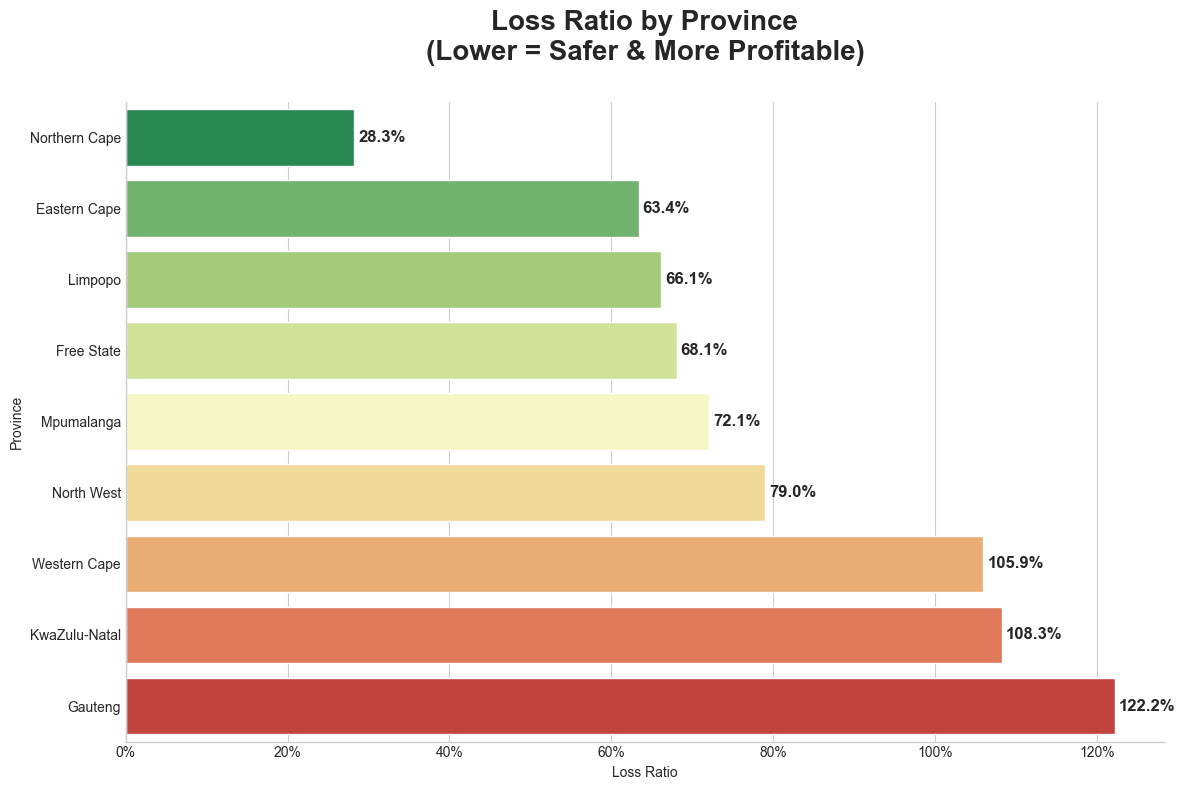

In [47]:
# 1. Loss Ratio by Province
province_risk = df.groupby('Province').agg({
    'TotalClaims': 'sum',
    'TotalPremium': 'sum',
    'PolicyID': 'nunique'
}).reset_index()
province_risk['LossRatio'] = province_risk['TotalClaims'] / province_risk['TotalPremium']
province_risk = province_risk.sort_values('LossRatio')

plt.figure(figsize=(12, 8))
ax = sns.barplot(data=province_risk, y='Province', x='LossRatio', palette='RdYlGn_r')
for i, v in enumerate(province_risk['LossRatio']):
    ax.text(v + 0.005, i, f'{v:.1%}', va='center', fontweight='bold', fontsize=12)
plt.title('Loss Ratio by Province\n(Lower = Safer & More Profitable)', fontsize=20, fontweight='bold', pad=30)
plt.xlabel('Loss Ratio')
plt.ylabel('Province')
ax.set_xticklabels([f'{int(x*100)}%' for x in ax.get_xticks()])
sns.despine()
plt.tight_layout()

# GUARANTEED SAVE
plt.savefig(FIGURES_PATH / "01_loss_ratio_by_province.png", dpi=300, bbox_inches='tight')
plt.savefig(FIGURES_PATH / "01_loss_ratio_by_province.pdf", bbox_inches='tight')
plt.show()

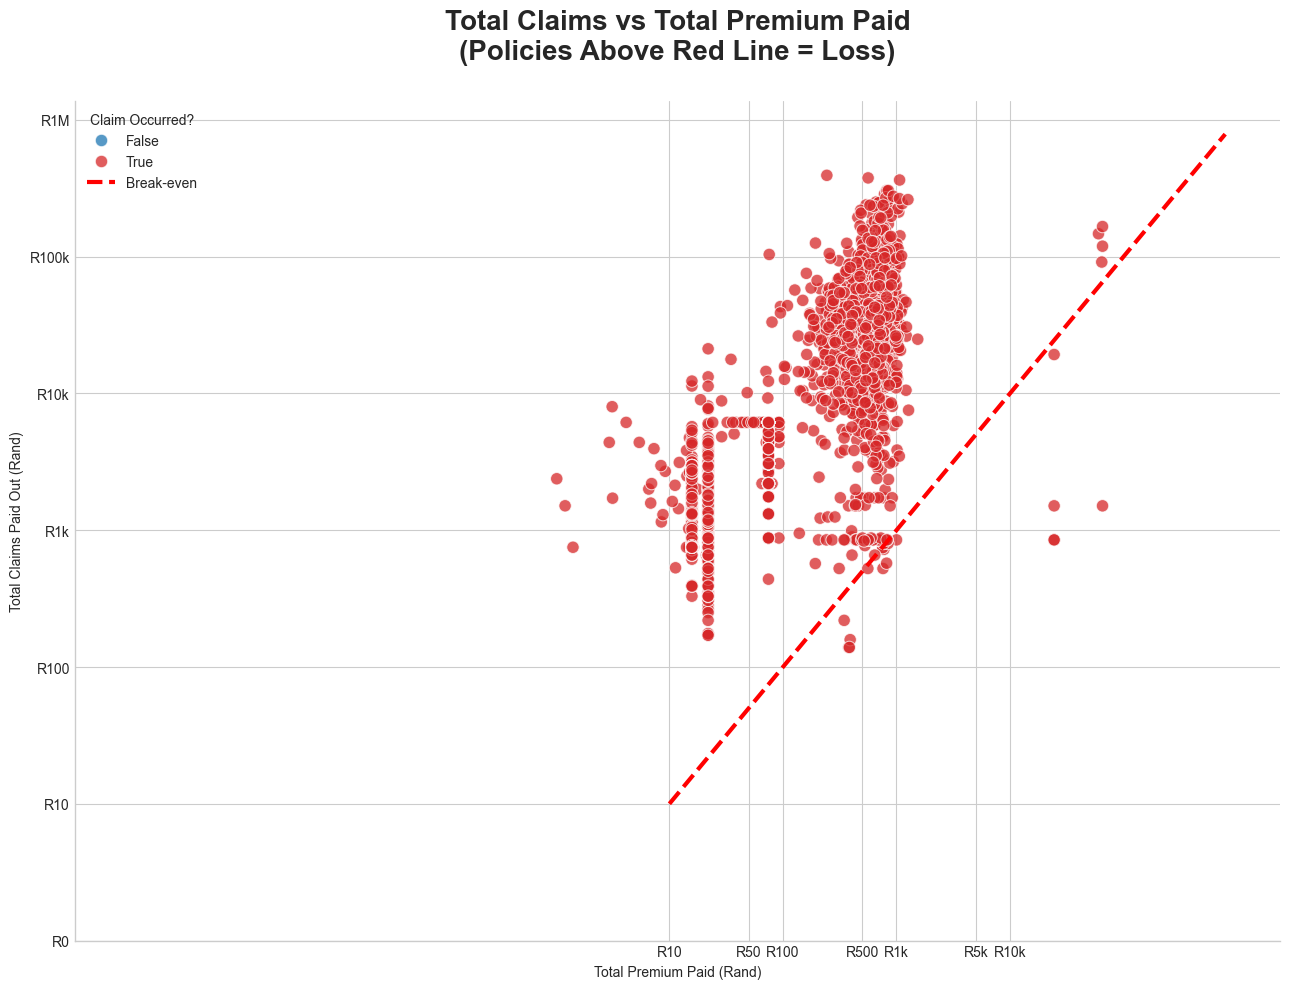

In [48]:
# 2. Claims vs Premium Scatter
claimed = df[df['TotalClaims'] > 0]
no_claim = df[df['TotalClaims'] == 0].sample(4000, random_state=42)
sample_df = pd.concat([claimed, no_claim]).sample(frac=1, random_state=42)

plt.figure(figsize=(13, 10))
sns.scatterplot(data=sample_df, x='TotalPremium', y='TotalClaims',
                hue=(sample_df['TotalClaims'] > 0),
                palette={False: '#1f77b4', True: '#d62728'}, alpha=0.75, s=80)
plt.xscale('log')
plt.yscale('log')
max_val = max(sample_df['TotalPremium'].max(), sample_df['TotalClaims'].max()) * 2
plt.plot([10, max_val], [10, max_val], '--', color='red', linewidth=3, label='Break-even')
plt.xticks([10, 50, 100, 500, 1000, 5000, 10000], ['R10', 'R50', 'R100', 'R500', 'R1k', 'R5k', 'R10k'])
plt.yticks([1, 10, 100, 1000, 10000, 100000, 1000000], ['R0', 'R10', 'R100', 'R1k', 'R10k', 'R100k', 'R1M'])
plt.title('Total Claims vs Total Premium Paid\n(Policies Above Red Line = Loss)', fontsize=20, fontweight='bold', pad=30)
plt.xlabel('Total Premium Paid (Rand)')
plt.ylabel('Total Claims Paid Out (Rand)')
plt.legend(title='Claim Occurred?', loc='upper left')
sns.despine()
plt.tight_layout()

plt.savefig(FIGURES_PATH / "02_claims_vs_premium.png", dpi=300, bbox_inches='tight')
plt.savefig(FIGURES_PATH / "02_claims_vs_premium.pdf", bbox_inches='tight')
plt.show()

C:\Users\YODAHE\AppData\Local\Temp\ipykernel_328\282872576.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=claim_data, x='VehicleType', y='TotalClaims', palette='Set3')


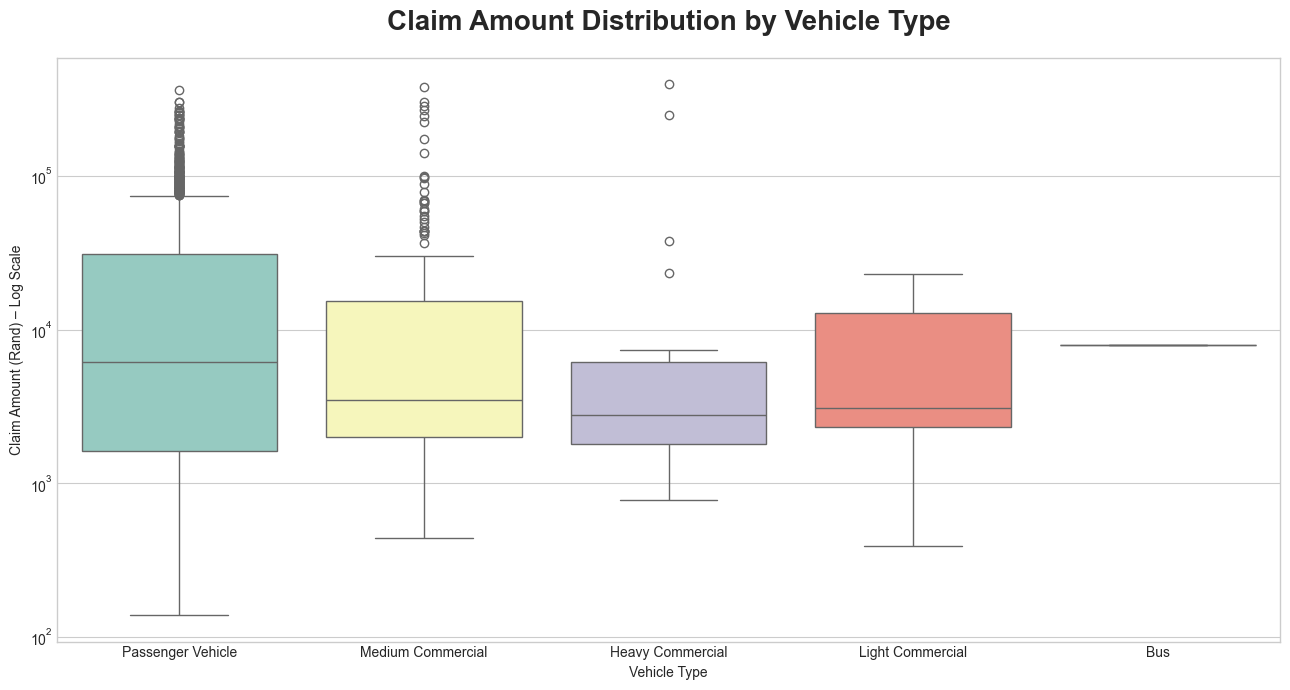

In [49]:
# 3. Claim Severity by Vehicle Type
top_vehicles = df['VehicleType'].value_counts().head(6).index
claim_data = df[(df['TotalClaims'] > 0) & df['VehicleType'].isin(top_vehicles)]

plt.figure(figsize=(13, 7))
sns.boxplot(data=claim_data, x='VehicleType', y='TotalClaims', palette='Set3')
plt.yscale('log')
plt.title('Claim Amount Distribution by Vehicle Type', fontsize=20, fontweight='bold', pad=20)
plt.ylabel('Claim Amount (Rand) – Log Scale')
plt.xlabel('Vehicle Type')
plt.tight_layout()

plt.savefig(FIGURES_PATH / "03_claim_severity_vehicle.png", dpi=300, bbox_inches='tight')
plt.savefig(FIGURES_PATH / "03_claim_severity_vehicle.pdf", bbox_inches='tight')
plt.show()

C:\Users\YODAHE\AppData\Local\Temp\ipykernel_328\1924451015.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=gender_risk, x='Gender', y='LossRatio', palette='Set2')
C:\Users\YODAHE\AppData\Local\Temp\ipykernel_328\1924451015.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'{int(y*100)}%' for y in ax.get_yticks()])


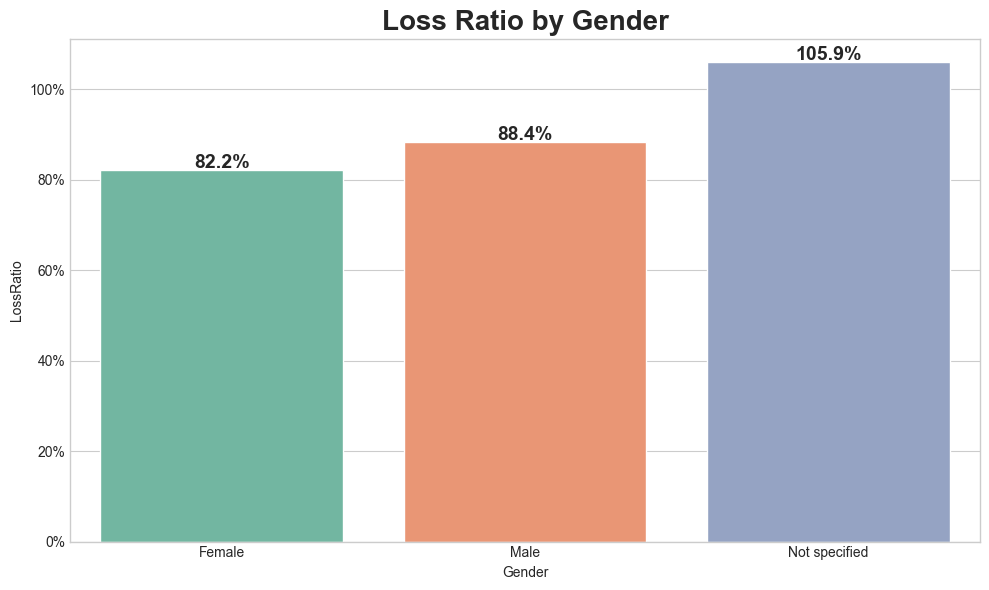

In [50]:
# 4. Loss Ratio by Gender
gender_risk = df.groupby('Gender').agg({'TotalClaims': 'sum', 'TotalPremium': 'sum'}).reset_index()
gender_risk['LossRatio'] = gender_risk['TotalClaims'] / gender_risk['TotalPremium']

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=gender_risk, x='Gender', y='LossRatio', palette='Set2')
for i, v in enumerate(gender_risk['LossRatio']):
    ax.text(i, v + 0.005, f'{v:.1%}', ha='center', fontweight='bold', fontsize=14)
plt.title('Loss Ratio by Gender', fontsize=20, fontweight='bold')
ax.set_yticklabels([f'{int(y*100)}%' for y in ax.get_yticks()])
plt.tight_layout()

plt.savefig(FIGURES_PATH / "04_loss_ratio_gender.png", dpi=300, bbox_inches='tight')
plt.show()

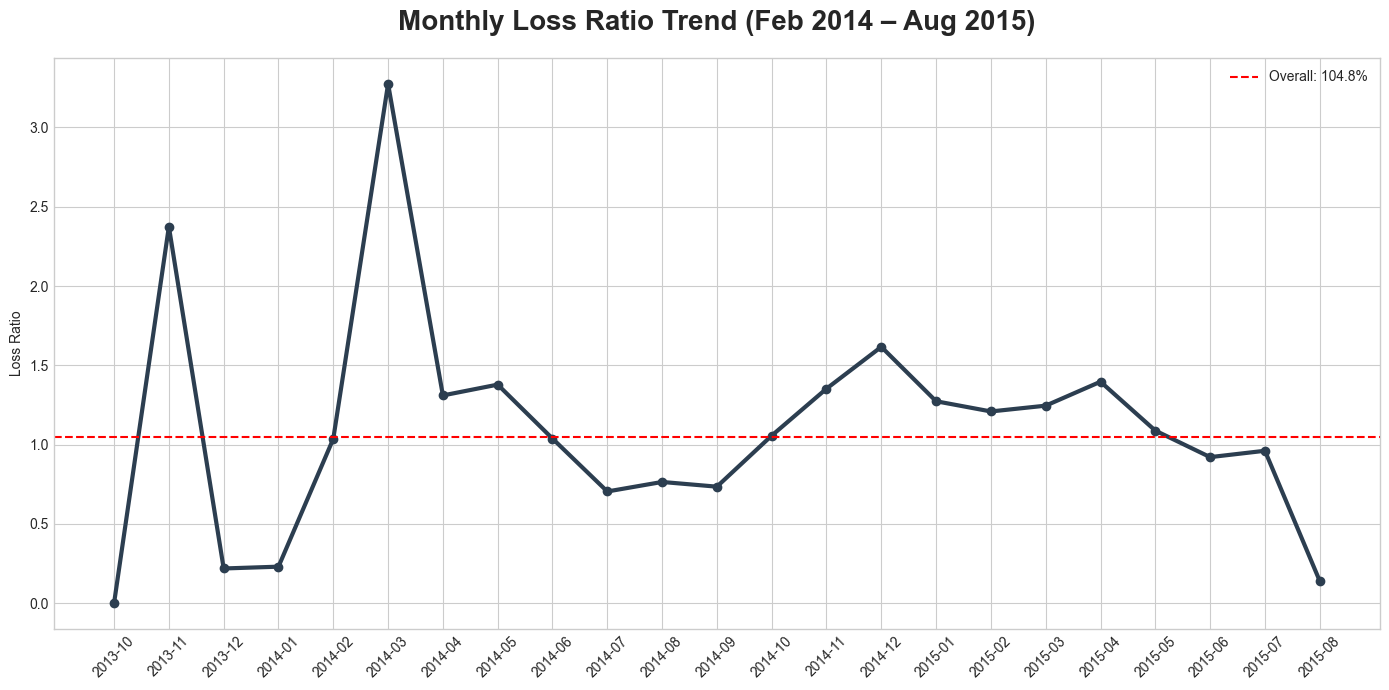

In [51]:
# 5. Monthly Trend
df['TransactionMonth'] = pd.to_datetime(df['TransactionMonth'])
monthly = df.groupby(df['TransactionMonth'].dt.to_period('M')).agg({
    'TotalPremium': 'sum', 'TotalClaims': 'sum'
}).reset_index()
monthly['LossRatio'] = monthly['TotalClaims'] / monthly['TotalPremium']
monthly['TransactionMonth'] = monthly['TransactionMonth'].astype(str)

plt.figure(figsize=(14, 7))
plt.plot(monthly['TransactionMonth'], monthly['LossRatio'], marker='o', linewidth=3, color='#2c3e50')
plt.title('Monthly Loss Ratio Trend (Feb 2014 – Aug 2015)', fontsize=20, fontweight='bold', pad=20)
plt.axhline(y=overall_loss_ratio, color='red', linestyle='--', label=f'Overall: {overall_loss_ratio:.1%}')
plt.ylabel('Loss Ratio')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

plt.savefig(FIGURES_PATH / "05_monthly_trend.png", dpi=300, bbox_inches='tight')
plt.show()

C:\Users\YODAHE\AppData\Local\Temp\ipykernel_328\377896316.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_risky, x='PostalCode', y='LossRatio', palette='Reds_r')


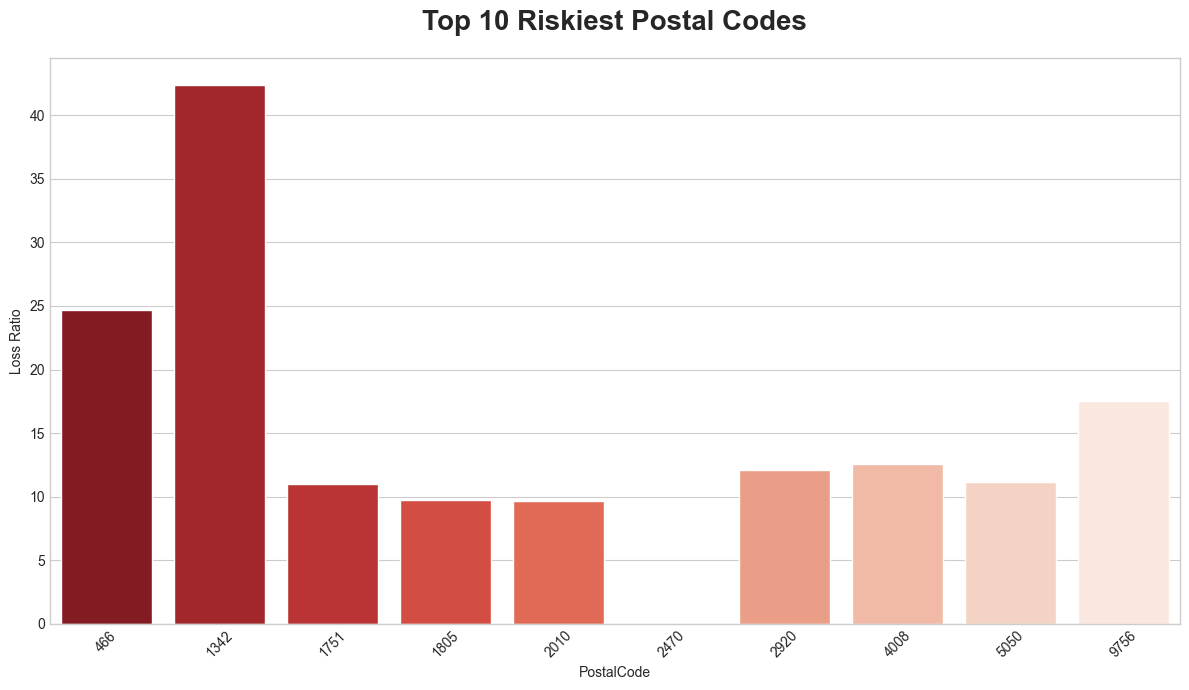

In [52]:
# 6. Top 10 Riskiest Postal Codes
postal_risk = df.groupby('PostalCode').agg({
    'TotalClaims': 'sum', 'TotalPremium': 'sum'
}).reset_index()
postal_risk['LossRatio'] = postal_risk['TotalClaims'] / postal_risk['TotalPremium']
top_risky = postal_risk.nlargest(10, 'LossRatio')

plt.figure(figsize=(12, 7))
sns.barplot(data=top_risky, x='PostalCode', y='LossRatio', palette='Reds_r')
plt.title('Top 10 Riskiest Postal Codes', fontsize=20, fontweight='bold', pad=20)
plt.ylabel('Loss Ratio')
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig(FIGURES_PATH / "06_riskiest_postalcodes.png", dpi=300, bbox_inches='tight')
plt.show()

In [53]:
print("All figures successfully saved:")
for file in sorted(FIGURES_PATH.glob("*.*")):
    print("   ", file.name)

All figures successfully saved:
    01_loss_ratio_by_province.pdf
    01_loss_ratio_by_province.png
    02_claims_vs_premium.pdf
    02_claims_vs_premium.png
    03_claim_severity_vehicle.pdf
    03_claim_severity_vehicle.png
    04_loss_ratio_gender.png
    05_monthly_trend.png
    06_riskiest_postalcodes.png
    claim_severity_by_vehicle.pdf
    claim_severity_by_vehicle.png
    claims_vs_premium_scatter.pdf
    claims_vs_premium_scatter.png
    loss_ratio_by_province.pdf
    loss_ratio_by_province.png
